# FinTech Project: Corporate Spend Analysis & AI Categorization

## Project Goal
This notebook tackles two core projects inspired by leading FinTech companies in the spend management space. The goal is to analyze a real-world dataset of corporate card transactions to uncover insights and build an AI-powered tool.

* **Project 1: Corporate Spending Analysis:** We'll act as data consultants for a spend management platform, identifying patterns of inefficient spending that their product could help solve.
* **Project 2: AI-Powered Expense Categorization:** We'll build a proof-of-concept for a core feature of modern FinTech platforms: automatically categorizing messy transaction data using a Large Language Model (Google's Gemini).

## Part 0: Setup and Data Consolidation 📂

Our first step is to prepare the environment. We'll **import the necessary libraries** and combine the multiple monthly CSV files into a **single, master DataFrame** for analysis.

In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import time

# For the AI part, import google generative AI
import google.generativeai as genai
from dotenv import load_dotenv

# Setting a nice style for our plots
sns.set_style("whitegrid")
print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# Define the path to your data folder
path = 'data/' 

all_files = glob.glob(os.path.join(path, "*.csv"))

df_list = []

print(f"Found {len(all_files)} files to merge.")
for f in all_files:
    try:
        df = pd.read_csv(f, encoding='utf-8')
        df_list.append(df)
    except UnicodeDecodeError:
        print(f"Could not read {f} with utf-8, trying latin1...")
        df = pd.read_csv(f, encoding='latin1')
    except Exception as e:
        print(f"Could not read file {f}. Error: {e}")

master_df = pd.concat(df_list, ignore_index=True)

print("\nData combined successfully!")
print(f"Total Transactions: {master_df.shape[0]:,}")
print(f"Total Columns: {master_df.shape[1]}")
master_df.head()

Found 48 files to merge.

Data combined successfully!
Total Transactions: 10,433
Total Columns: 6


,Sent for Payment Date,Approved Amount (rpt),Category Level 1,Statement date,Gross amount,Gross Amount
0,01/04/2019,514.03,"Travel, venue hire and exhibition services",NaN,NaN,NaN
1,30/04/2019,525.00,"Travel, venue hire and exhibition services",NaN,NaN,NaN
2,16/04/2019,527.25,"Travel, venue hire and exhibition services",NaN,NaN,NaN
3,29/04/2019,529.65,"Advertising, Marketing & Media",NaN,NaN,NaN
4,29/04/2019,531.16,"Advertising, Marketing & Media",NaN,NaN,NaN


## Part 1: Corporate Spending Analysis & Insights 📊
With our data loaded, we can now dive into the analysis. The goal here is to find **actionable insights** that a spend management company could use to pitch its value proposition.

***

### Step 1.1: Data Cleaning and Preparation
Real-world data is never perfect. We need to **clean and standardize it** before we can analyze it. This involves standardizing column names, converting data types, and handling missing values.
This is the most critical step. We will clean the data using the specific column names, intelligently consolidating the multiple "amount" columns into one reliable field. We then standardize the column names to make our analysis code clean and reusable.

In [3]:
# Let's see the original column names to confirm
print("Original column names:", master_df.columns.tolist())

# CONSOLIDATE the multiple amount columns into a single 'amount' column
# This revised method is cleaner and avoids the FutureWarning by creating the final series first.
amount1 = pd.to_numeric(master_df['Approved Amount (rpt)'], errors='coerce')
amount2 = pd.to_numeric(master_df['Gross Amount'], errors='coerce')
amount3 = pd.to_numeric(master_df['Gross amount'], errors='coerce')
master_df['amount'] = amount1.fillna(amount2).fillna(amount3)

# RENAME other essential columns to the standard names
rename_map = {
    'Sent for Payment Date': 'transaction_date',
    'Category Level 1': 'expense_area'
}
master_df.rename(columns=rename_map, inplace=True)

# Select only the final, clean columns we need for the analysis
# This effectively drops the original, messy columns.
final_columns = ['transaction_date', 'amount', 'expense_area']
master_df = master_df[final_columns].copy()

print("\nSuccessfully consolidated amount columns into a single 'amount' column.")


# --- DATA TYPE CONVERSION & FINAL CLEANUP (WITH WARNING FIX) ---
master_df['transaction_date'] = pd.to_datetime(master_df['transaction_date'], errors='coerce', dayfirst=True)
master_df.dropna(subset=['transaction_date', 'amount'], inplace=True)

# This is the corrected way to fill missing values without a warning.
master_df['expense_area'] = master_df['expense_area'].fillna('Unknown')

# Checking the data
print("\nFinal clean DataFrame info:")
master_df.info()
master_df.head()

Original column names: ['Sent for Payment Date', 'Approved Amount (rpt)', 'Category Level 1', 'Statement date', 'Gross amount', 'Gross Amount']

Successfully consolidated amount columns into a single 'amount' column.

Final clean DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 2789 entries, 0 to 10391
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_date  2789 non-null   datetime64[ns]
 1   amount            2789 non-null   float64       
 2   expense_area      2789 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 87.2+ KB


,transaction_date,amount,expense_area
0,2019-04-01,514.03,"Travel, venue hire and exhibition services"
1,2019-04-30,525.00,"Travel, venue hire and exhibition services"
2,2019-04-16,527.25,"Travel, venue hire and exhibition services"
3,2019-04-29,529.65,"Advertising, Marketing & Media"
4,2019-04-29,531.16,"Advertising, Marketing & Media"


## Step 1.2: Exploratory Data Analysis (EDA)
Now for the fun part: exploring the data to uncover trends.

What are the highest spending categories?
This helps us understand where the bulk of the money is going.

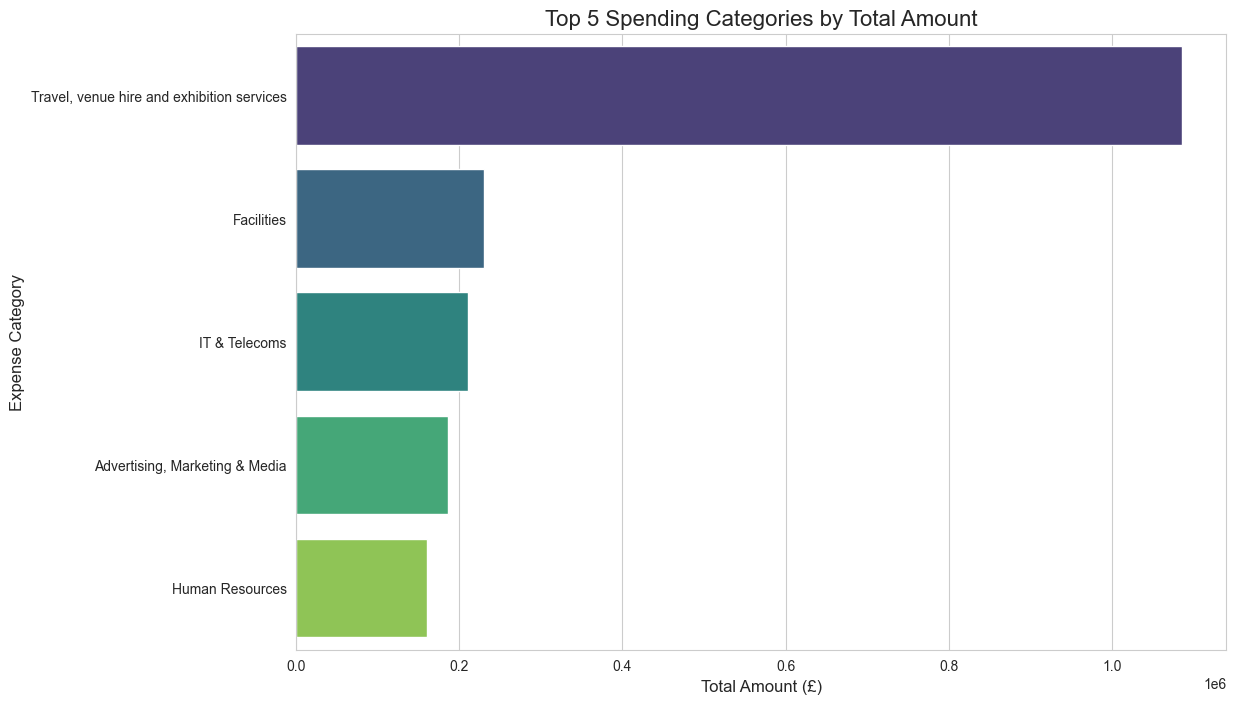

In [4]:
# Group by the expense category and sum the amounts
top_categories = master_df.groupby('expense_area')['amount'].sum().sort_values(ascending=False).head(5)

# Create the plot (with the warning fix)
plt.figure(figsize=(12, 8))
sns.barplot(
    x=top_categories.values, 
    y=top_categories.index, 
    palette='viridis',
    hue=top_categories.index,
    legend=False              
)
plt.title('Top 5 Spending Categories by Total Amount', fontsize=16)
plt.xlabel('Total Amount (£)', fontsize=12)
plt.ylabel('Expense Category', fontsize=12)
plt.show()

### How does overall spending trend over time?
This gives us a high-level view of procurement activity.

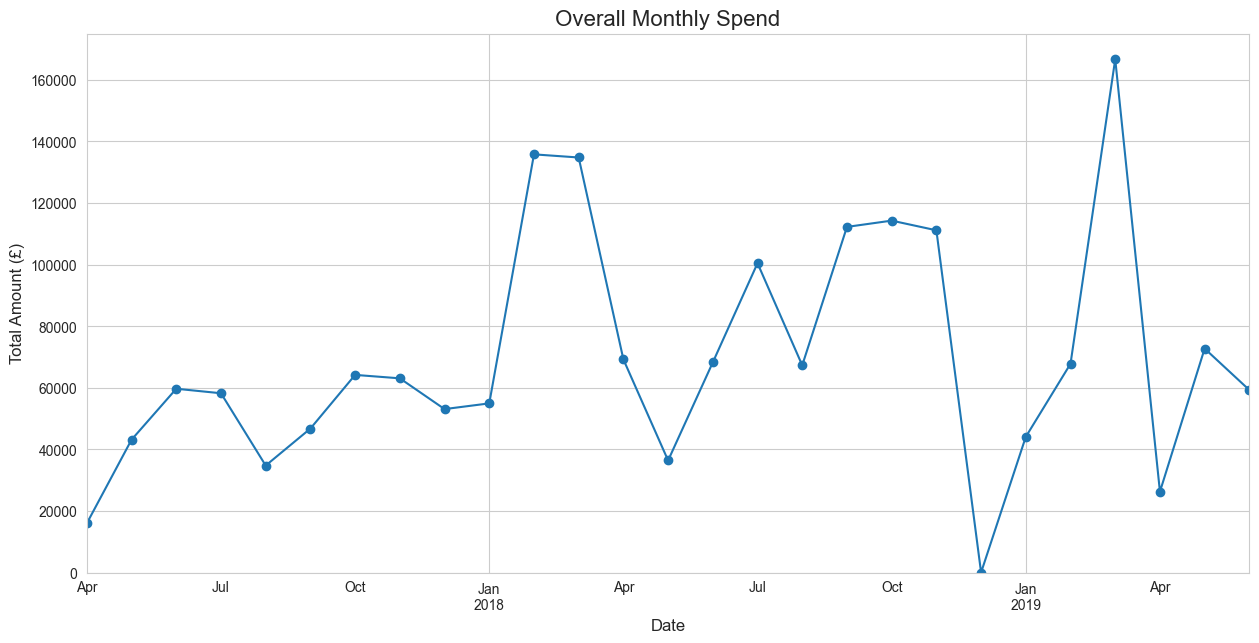

In [5]:
# For trending, we'll resample the data by month
monthly_spend = master_df.set_index('transaction_date')['amount'].resample('ME').sum()

# Create the plot
plt.figure(figsize=(15, 7))
monthly_spend.plot(kind='line', marker='o', linestyle='-')
plt.title('Overall Monthly Spend', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Amount (£)', fontsize=12)
plt.ylim(bottom=0)
plt.show()


## Step 1.3: Key Business Insights 💡

Based on our analysis, we can formulate several insights as if we were presenting them to a potential customer.

* **Insight 1: Extreme Concentration in Travel Spend:** A hugely disproportionate amount of spending is concentrated in "Travel, venue hire and exhibition services." This single category's spending is more than the next four largest categories combined. This suggests a critical need for strong travel policies and negotiating power with travel-related vendors.

* **Insight 2: Volatile and Seasonal Monthly Spending:** The trend chart shows significant peaks and troughs in monthly spending, indicating high volatility. Notably, spending consistently peaks around January, suggesting a seasonal or annual pattern. This volatility makes budgeting difficult, and a platform with real-time dashboards could help finance teams manage this predictable but sharp seasonality.

* **Insight 3: Significant Spend in Operational Categories:** Following travel, there are substantial and comparable levels of spending in core operational areas like "Facilities" and "IT & Telecoms." Optimizing these costs, even by a small percentage, could lead to significant savings.

## Part 2: AI-Powered Category Standardization 🤖
Since we don't have merchant names, we've pivoted this project to another high-value AI task: standardizing the government's official expense categories into modern, universally understood business categories. This showcases how AI can be used for data enrichment.

***

### Step 2.1: Setup Gemini API
First, we need to securely load our API key. Make sure you have a `.env` file in your project folder with the line `GEMINI_API_KEY="YOUR_API_KEY_HERE"`.

In [19]:
# Load environment variables from .env file
load_dotenv()

# Configure the API key from the environment variable
try:
    api_key = os.getenv("GEMINI_API_KEY")
    if not api_key:
        raise ValueError("GEMINI_API_KEY not found in .env file.")
    genai.configure(api_key=api_key)
    print("Gemini API configured successfully.")
except Exception as e:
    print(e)

# Create the model instance
model = genai.GenerativeModel('gemini-2.0-flash')

Gemini API configured successfully.


## Step 2.2: Prompt Engineering for Standardization
Our new prompt will teach the AI how to translate the government categories into business categories.

In [20]:
# New prompt to standardize existing categories
pivot_prompt_template = """
You are an expert expense categorization system for a fintech company.
Your task is to analyze an official government expense category and map it to one of these specific, modern business categories:
Software & Subscriptions, Travel & Lodging, Office Supplies, Marketing & Advertising, Food & Entertainment, Professional Services, Utilities, Recruitment & HR, Other.

Analyze the following government categories and provide only the modern business category name.

Government Category: "Travel, venue hire and exhibition services"
Modern Category: Travel & Lodging

Government Category: "ICT Software"
Modern Category: Software & Subscriptions

Government Category: "Advertising, Marketing & Media"
Modern Category: Marketing & Advertising

Government Category: "Consultants"
Modern Category: Professional Services

Government Category: "Stationery and Office Equipment"
Modern Category: Office Supplies

Government Category: "{gov_category}"
Modern Category:
"""
print("Pivot prompt template created.")

Pivot prompt template created.


## Step 2.3: Applying the Model to Existing Categories
We'll define a function to call the API and test it on the unique categories found in our dataset.

In [21]:
def standardize_category(gov_category: str):
    """Sends a government category to the Gemini API and returns a standardized business category."""
    if not isinstance(gov_category, str) or not gov_category.strip() or gov_category == 'Unknown':
        return "Uncategorized"
    try:
        prompt = pivot_prompt_template.format(gov_category=gov_category)
        response = model.generate_content(prompt)
        category = response.text.strip().replace("*", "")
        return category
    except Exception as e:
        print(f"An error occurred for '{gov_category}': {e}")
        return "API Error"

# Get the unique categories from our data to test
sample_categories = master_df['expense_area'].dropna().unique()

print("--- Testing AI Category Standardization ---")
for cat in sample_categories:
    standard_category = standardize_category(cat)
    print(f"'{cat}'  ->  '{standard_category}'")
    time.sleep(1) 

--- Testing AI Category Standardization ---
'Travel, venue hire and exhibition services'  ->  'Travel & Lodging'
'Advertising, Marketing & Media'  ->  'Marketing & Advertising'
'Human Resources'  ->  'Recruitment & HR'
'IT & Telecoms'  ->  'Software & Subscriptions'
'Facilities'  ->  'Utilities'
'Professional Services'  ->  'Professional Services'
'Exam Board Fees'  ->  'Other'


## Step 2.4: Applying to the Full Dataset
Once satisfied, we can apply the function to create a new, clean category column in your DataFrame.

In [24]:
# 1. Get the list of unique categories from your DataFrame
unique_categories = master_df['expense_area'].dropna().unique()
print(f"Found {len(unique_categories)} unique categories to process.")

# 2. Create a mapping dictionary by calling the API only once per unique category
category_map = {}
for cat in unique_categories:
    print(f"Processing: '{cat}'...")
    standard_category = standardize_category(cat)
    category_map[cat] = standard_category
    # A 5-second delay is very safe for the free tier's per-minute limit.
    time.sleep(5)

print("\n Category Mapping Complete")
print(category_map)

# 3. Use the .map() function to apply this dictionary to the entire column.
# This is extremely fast and makes zero new API calls.
master_df['ai_category'] = master_df['expense_area'].map(category_map)

# 4. FIX: Correctly fill any potential NaN values without a FutureWarning.
master_df['ai_category'] = master_df['ai_category'].fillna('Uncategorized')

print("\nStandardization applied efficiently to the entire dataset!")


# --- FINAL CHECK ---
print("\nValue counts of the new AI-generated categories:")
print(master_df['ai_category'].value_counts())

print("\nDataFrame head with the new column:")
print(master_df[['expense_area', 'ai_category']].head(20))

Found 7 unique categories to process.
Processing: 'Travel, venue hire and exhibition services'...
Processing: 'Advertising, Marketing & Media'...
Processing: 'Human Resources'...
Processing: 'IT & Telecoms'...
Processing: 'Facilities'...
Processing: 'Professional Services'...
Processing: 'Exam Board Fees'...

--- Category Mapping Complete ---
{'Travel, venue hire and exhibition services': 'Travel & Lodging', 'Advertising, Marketing & Media': 'Marketing & Advertising', 'Human Resources': 'Recruitment & HR', 'IT & Telecoms': 'Software & Subscriptions', 'Facilities': 'Utilities', 'Professional Services': 'Professional Services', 'Exam Board Fees': 'Other'}

Standardization applied efficiently to the entire dataset!

Value counts of the new AI-generated categories:
ai_category
Travel & Lodging            1579
Utilities                    336
Software & Subscriptions     318
Marketing & Advertising      315
Recruitment & HR             231
Professional Services          8
Other             